In [ ]:
# Code line to install the required libraries

%pip install -r requirements.txt

: 

In [12]:
# Necessary imports

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import mlflow
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from sklearn.dummy import DummyClassifier


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

In [5]:
# Data Loading and Preprocessing

# https://stackoverflow.com/questions/58962330/i-cannot-train-tensorflow

def load_images_with_labels(data_directory):
    images = []
    labels = []

    for folder_name in os.listdir(data_directory):
        folder_path = os.path.join(data_directory, folder_name)
        if os.path.isdir(folder_path):
            label = folder_name
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                
                try:    
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    # Check if the image is not empty
                    if img is not None:
                        # Resize images to 100x100 for visualization
                        img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
                        images.append(img)
                        labels.append(label)
                except:
                    print("Error loading image")

    return np.array(images), np.array(labels)


In [6]:
# Load images with corresponding labels
data_directory = "fruits"  
X, y = load_images_with_labels(data_directory)

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training, validation, and test sets, 70, 15, 15
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [7]:
# Define Transformer class to reshape the images

class ImageReshaper(BaseEstimator, TransformerMixin):
    def __init__(self, target_shape):
        # Constructor for the ImageReshaper class
        self.target_shape = target_shape

    def fit(self, X, y=None):
        # Fit method required by TransformerMixin
        # Transformer does not need to learn anything, so just retuzrn self
        return self

    def transform(self, X):
        # Transform method required by TransformerMixin
        # Reshapes each image in the input array to the target shape
        reshaped_X = np.array([cv2.resize(img, self.target_shape, interpolation=cv2.INTER_LINEAR) for img in X])
        return reshaped_X

    
# Reshaping images so the CNN can handle them
reshaper = ImageReshaper(target_shape=(50, 50))
X_train_reshaped = reshaper.fit_transform(X_train)
X_test_reshaped = reshaper.transform(X_test)
X_val_reshaped = reshaper.transform(X_val)

# # Test the transformer
# print(f"Original shape: {X_train.shape}")
# print(f"Transformed shape: {X_train_reshaped.shape}")


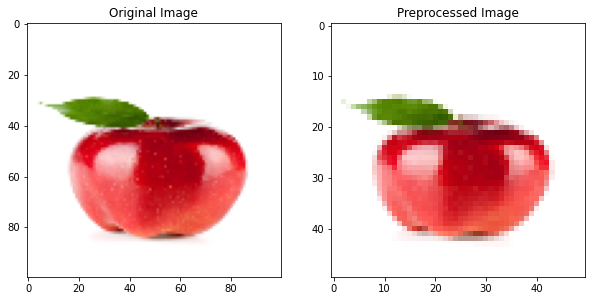

In [8]:
# Image Preprocessing Visualization
sample_image = 0 # Change to look at other images
original_image = X[sample_image]
processed_image = reshaper.transform(original_image[np.newaxis, ...])[0]

# Plot the images side by side with RGB channels
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.title('Preprocessed Image')
plt.show()



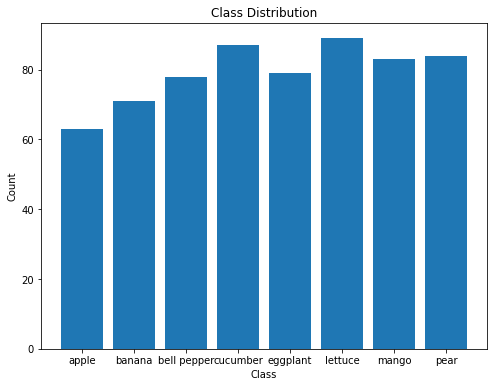

In [9]:
# Show the class distribution
classes = np.unique(y, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(classes[0], classes[1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


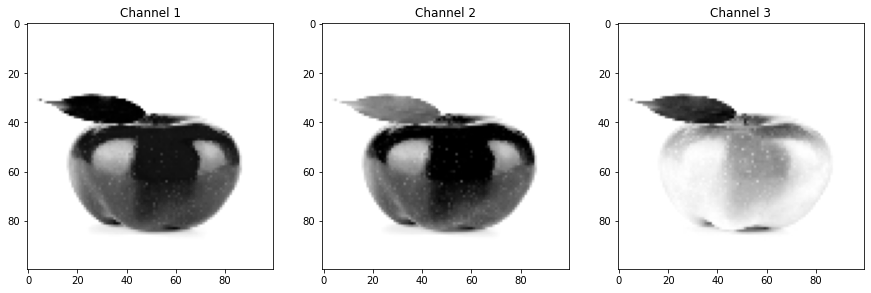

In [10]:
# Channel Visualization
sample_image = 0  # Change to look at other images
image = X[sample_image]

# Plot the different BGR color channels of the image
plt.figure(figsize=(15, 5))
for i in range(image.shape[2]):
    plt.subplot(1, image.shape[2], i + 1)
    plt.imshow(image[:, :, i], cmap='gray')
    plt.title(f'Channel {i + 1}')

plt.show()

In [10]:
# MLflow Setup
mlflow.set_experiment("fruit-classification")
mlflow.set_tracking_uri("http://localhost:5000")


MlflowException: API request to http://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception type object 'Retry' has no attribute 'DEFAULT_BACKOFF_MAX'

In [6]:
def train_cnn_to_find_optimal(X_train_reshaped, y_train, X_val_reshaped, y_val, X_test_reshaped, y_test,
                               n_iterations=10,
                               train_size=0.7,
                               batch_size_options=[32, 64, 128, 256, 512],
                               epoch_options=[5, 10, 15, 20, 30],
                               optimizer_options=['adam', 'rmsprop', 'adagrad', 'sgd'],
                               loss_optoins=['sparse_categorical_crossentropy', 'categorical_crossentropy', 'mean_squared_error']):
    """
    Trains and evaluates CNN models with different hyperparameters, and logs the results and hyperparameters using mlflow.

    Parameters:
    -----------
    X_train_reshaped : np.ndarray
        Training set

    y_train : np.ndarray
        Training set target label

    X_val_reshaped : np.ndarray
        Validation set

    y_val : np.ndarray
        Validation set target label

    X_test_reshaped : np.ndarray
        Test set

    y_test : np.ndarray
        Test set target label

    n_iterations : int
        Number of iterations to try hyperparameters. Default is 10

    batch_size_options : list
        List of batch sizes to try. Default is [32, 64, 128, 256, 512]

    epochs_options : list
        List of epochs to try. Default is [5, 10, 15, 20, 30]

    optimizer_options : list
        List of optimizers to try. Default is ['adam', 'rmsprop', 'adagrad', 'sgd'].

    loss_optoins : list
        List of losses to try. Default is ['sparse_categorical_crossentropy', 'categorical_crossentropy', 'mean_squared_error'].

    Returns:
    --------
    None
    """

    # Split the training set into a smaller portion
    X_train_small_reshaped, _, y_train_small, _ = train_test_split(X_train_reshaped, y_train, train_size=train_size, random_state=42)

    best_score = 0.0
    best_params = {}

    for _ in range(n_iterations):
        batch_size = np.random.choice(batch_size_options)
        epochs = np.random.choice(epoch_options)
        optimizer = np.random.choice(optimizer_options)
        loss = np.random.choice(loss_optoins)

        with mlflow.start_run(run_name=f'run_batch_size={batch_size}_epochs={epochs}_optimizer={optimizer}_loss={loss}', nested=True):
            model = keras.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.MaxPooling2D((2, 2)),
                layers.Flatten(),
                layers.Dense(128, activation='relu'),
                layers.Dense(len(np.unique(y_train)), activation='softmax')
            ])

            # Compile the model
            model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

            # Ensure one-hot encoding for categorical crossentropy
            # https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
            if loss == 'categorical_crossentropy':
                y_train_small_encoded = keras.utils.to_categorical(y_train_small, num_classes=len(np.unique(y_train)))
                y_val_encoded = keras.utils.to_categorical(y_val, num_classes=len(np.unique(y_val)))
            else:
                y_train_small_encoded = y_train_small
                y_val_encoded = y_val

            # Train the model
            model.fit(X_train_small_reshaped, y_train_small_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val_reshaped, y_val_encoded))
            y_pred = model.predict(X_test_reshaped)
            y_pred_classes = np.argmax(y_pred, axis=1)
            score = accuracy_score(y_test, y_pred_classes)

            # Log hyperparameters and results
            mlflow.log_param('batch_size', batch_size)
            mlflow.log_param('epochs', epochs)
            mlflow.log_param('optimizer', optimizer)
            mlflow.log_param('loss', loss)
            mlflow.log_metric('accuracy', score)

            # Ensure the best model is saved
            if score > best_score:
                best_score = score
                best_params = {'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer, 'loss': loss}
            
            # For debugging
            print(f"Iteration: {_ + 1}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}, loss={loss}, accuracy={score}")

        mlflow.end_run()

    # Log the best hyperparameters and score
    mlflow.log_param('best_batch_size', best_params['batch_size'])
    mlflow.log_param('best_epochs', best_params['epochs'])
    mlflow.log_param('best_optimizer', best_params['optimizer'])
    mlflow.log_param('best_loss', best_params['loss'])
    mlflow.log_metric('best_accuracy', best_score)

    # Print the best hyperparameters and score for the user
    print('Best hyperparameters:', best_params)
    print('Best score:', best_score)

    return model

# Train the model
with mlflow.start_run():
    best_model = train_cnn_to_find_optimal(X_train_reshaped, y_train, X_val_reshaped, y_val, X_test_reshaped, y_test)


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

In [ ]:
def train_and_evaluate_cnn(X_train_reshaped, y_train, X_test_reshaped, y_test, batch_size, epochs, run_name,
                            chosen_optimizer='adagrad',
                            chosen_loss='sparse_categorical_crossentropy'):
    """
    Trains a CNN model with the specified hyperparameters and evaluates it on the test set. Logs the results and
    saves the trained model as an MLflow artifact.

    Parameters
    ----------
    X_train_reshaped : np.ndarray
        Training set

    y_train : np.ndarray
        Training set target label
        
    X_test_reshaped : np.ndarray
        Test set

    y_test : np.ndarray
        Test set target label

    batch_size : int
        The number of bacthes

    epochs : int
        The number of epochs

    run_name : str
        The name of the MLflow run

    optimizer: str
        The chosen optimizer. Default is 'adagrad'

    loss_choice : str
        The chosen loss. Default is 'sparse_categorical_crossentropy'

    Returns
    -------
    None
    """
    with mlflow.start_run(run_name=run_name, nested=True):
        optimizer = chosen_optimizer
        loss = chosen_loss

        model = keras.Sequential([
            keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
        ])

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        # Ensure one-hot encoding for categorical crossentropy
        if loss == 'categorical_crossentropy':
            y_train_encoded = keras.utils.to_categorical(y_train, num_classes=len(np.unique(y_train)))
        else:
            y_train_encoded = y_train

        # Train the model
        model.fit(X_train_reshaped, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2)

        # Evaluate on the test set
        y_pred = model.evaluate(X_test_reshaped, y_test)[1]
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Dummy Classifier
        dummy_clf = DummyClassifier(strategy='most_frequent')
        dummy_clf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)
        dummy_predictions = dummy_clf.predict(X_test.reshape((X_test.shape[0], -1)))
        dummy_accuracy = accuracy_score(y_test, dummy_predictions)

        # Visualization
        models = ['CNN', 'Dummy']
        accuracies = [y_pred, dummy_accuracy]

        plt.bar(models, accuracies, color=['blue', 'red'])
        plt.xlabel('Model')
        plt.ylabel('Accuracy')
        plt.title('Model Comparison')
        plt.show()

        # Display the confusion matrix
        c_m = confusion_matrix(y_test, y_pred_classes)
        print("Confusion Matrix:")
        print(c_m)
        mlflow.log_metric("confusion_matrix", np.trace(c_m))

        # Display the classification report
        c_r = classification_report(y_test, y_pred_classes)
        print("Classification Report:")
        print(c_r)

        # Display the accuracy
        acc = accuracy_score(y_test, y_pred_classes)
        print(f"Accuracy: {acc}")
        mlflow.log_metric("accuracy", acc)

        # Log hyperparameters and results
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param('optimizer', optimizer)
        mlflow.log_param('loss', loss)
        mlflow.log_metric('accuracy', accuracy_score(y_test, y_pred_classes))

        # Save the model as an artifact
        mlflow.tensorflow.log_model(model, "model")
        mlflow.end_run()

# Running the best model from the previous step
with mlflow.start_run():
    train_and_evaluate_cnn(X_train_reshaped, y_train,X_test_reshaped, y_test, batch_size=64, epochs=15, run_name='cnn_run_1')


Epoch 1/15
6/6 [==============================] - 3s 300ms/step - loss: 79.3856 - accuracy: 0.1299 - val_loss: 24.8285 - val_accuracy: 0.1348
Epoch 2/15
6/6 [==============================] - 1s 217ms/step - loss: 12.5181 - accuracy: 0.3446 - val_loss: 5.8972 - val_accuracy: 0.3596
Epoch 3/15
6/6 [==============================] - 1s 252ms/step - loss: 3.6509 - accuracy: 0.5169 - val_loss: 3.3237 - val_accuracy: 0.3483
Epoch 4/15
6/6 [==============================] - 1s 219ms/step - loss: 1.5279 - accuracy: 0.6215 - val_loss: 2.5721 - val_accuracy: 0.4157
Epoch 5/15
6/6 [==============================] - 1s 214ms/step - loss: 0.9718 - accuracy: 0.7147 - val_loss: 2.4963 - val_accuracy: 0.4494
Epoch 6/15
6/6 [==============================] - 1s 240ms/step - loss: 0.7476 - accuracy: 0.7768 - val_loss: 2.6765 - val_accuracy: 0.4382
Epoch 7/15
6/6 [==============================] - 1s 243ms/step - loss: 0.5816 - accuracy: 0.8136 - val_loss: 2.2900 - val_accuracy: 0.4831
Epoch 8/15
6/6 [=

2024/01/26 20:28:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Confusion Matrix:
[[ 4  0  2  0  0  0  2  1]
 [ 0  6  0  1  1  0  0  2]
 [ 3  1  3  0  1  0  5  0]
 [ 0  0  2  3  2  1  1  0]
 [ 2  0  0  1  9  0  0  1]
 [ 0  0  0  2  0 12  0  0]
 [ 0  4  1  0  0  0  8  1]
 [ 1  1  0  0  1  0  2  9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42         9
           1       0.50      0.60      0.55        10
           2       0.38      0.23      0.29        13
           3       0.43      0.33      0.38         9
           4       0.64      0.69      0.67        13
           5       0.92      0.86      0.89        14
           6       0.44      0.57      0.50        14
           7       0.64      0.64      0.64        14

    accuracy                           0.56        96
   macro avg       0.54      0.55      0.54        96
weighted avg       0.56      0.56      0.56        96

Accuracy: 0.5625
INFO:tensorflow:Assets written to: /var/folders/49/9m04ztz163z1g2tv8rl57yc

INFO:tensorflow:Assets written to: /var/folders/49/9m04ztz163z1g2tv8rl57ycc0000gq/T/tmpok7v31l1/model/data/model/assets


3/3 [==============================] - 0s 22ms/step


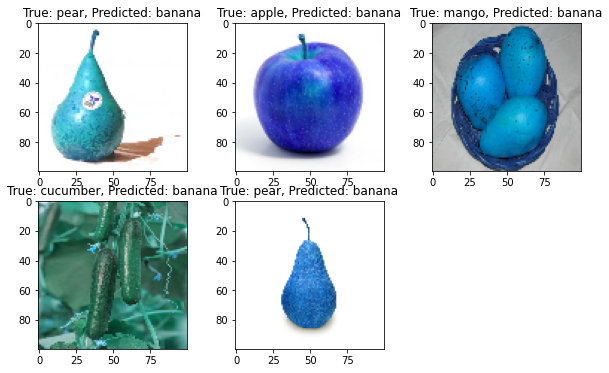

In [ ]:
# Error Analysis

# Not changing back to RGB to better understand the models errors

# Using the model from the previous step
model = keras.Sequential([
            keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
        ])

# Predict on the test set
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
incorrect_indices = np.where(y_pred_classes != y_test)[0]

# Display a few images where the model made errors
plt.figure(figsize=(10, 6))
for i, idx in enumerate(incorrect_indices[:5]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f'True: {label_encoder.classes_[y_test[idx]]}, Predicted: {label_encoder.classes_[y_pred_classes[idx]]}')

plt.show()

1/1 [==============================] - 0s 119ms/step


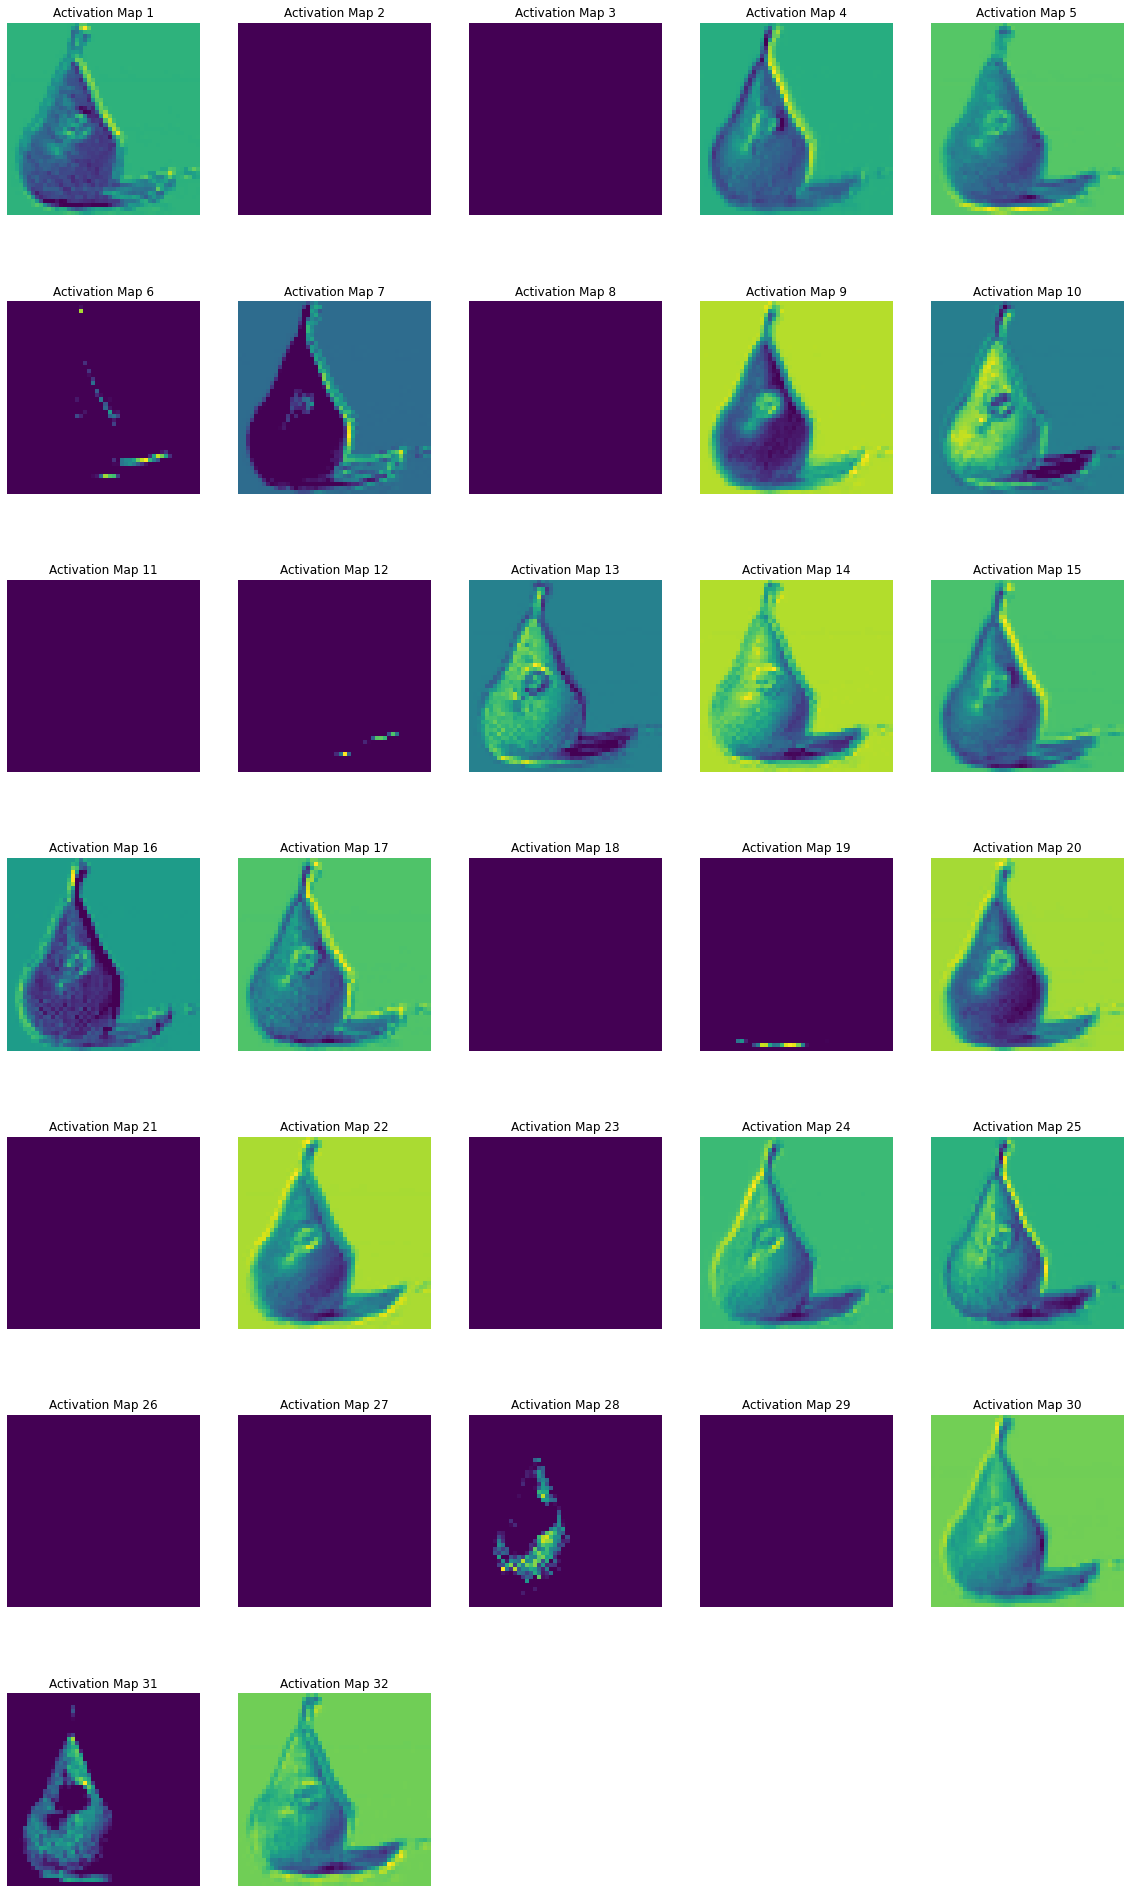

In [ ]:
# Activation Maps

# Not changing back to RGB to better uhnderstand the model

# Choose a sample image for visualization
sample_image = 0 # Change to look at other images
image = X_test_reshaped[sample_image][np.newaxis, ...]

# Creating a model to output intermediate layer activations
act_modell = Model(inputs=best_model.input, outputs=best_model.layers[0].output)  # Change the layer here
activations = act_modell.predict(image)

# Visualize the activation maps
activations_num = activations.shape[-1]
plt.figure(figsize=(20, 5 * (activations_num // 5 + 1)))

for i in range(activations_num):
    plt.subplot(activations_num // 5 + 1, 5, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.title(f'Activation Map {i + 1}')
    plt.axis('off')

plt.show()

In [ ]:
# Using MLflow UI with reshaped images

# Set the experiment id
mlflow.set_experiment(experiment_id="432972119018677489")

mlflow.autolog()
db = load_diabetes()

X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

# Create and train models.
rf = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=3)
rf.fit(X_train, y_train)

# Use the model to make predictions on the test dataset.
predictions = rf.predict(X_test)

2024/01/26 20:29:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/26 20:29:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/01/26 20:29:12 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/01/26 20:29:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2024/01/26 20:29:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '35ddd3425ffc4c9bb4eb5121a16f472e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [ ]:
# Loaded predictions from MLflow UI modifed to work with reshaped images

# Load the PyFuncModel
logged_model = 'runs:/5084e699a0e248c2af9835ec54cfd2df/model'
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Assuming X_test_reshaped is a 4D array with shape (n_samples, height, width, channels)
# Reshape each image to a 1D array with 10 elements
reshaped_array = X_test_reshaped.reshape((X_test_reshaped.shape[0], -1))[:, :10]

# Create a DataFrame with the correct column name and shape
df_test = pd.DataFrame({"image_data": reshaped_array[:, :10].tolist()})

# Print the DataFrame to debug
print("DataFrame:", df_test)

# Predict on the DataFrame
predictions = loaded_model.predict(df_test)

# Print or use the predictions as needed
print(predictions)

DataFrame:                                            image_data
0   [255, 255, 255, 255, 255, 255, 255, 255, 255, ...
1   [254, 253, 255, 254, 253, 255, 254, 253, 255, ...
2   [255, 255, 255, 255, 255, 255, 255, 255, 255, ...
3   [255, 255, 255, 255, 255, 255, 255, 255, 255, ...
4   [143, 143, 143, 142, 142, 142, 147, 147, 147, ...
..                                                ...
91      [126, 139, 98, 103, 121, 72, 83, 111, 58, 82]
92  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...
93           [2, 114, 73, 14, 131, 93, 5, 130, 90, 8]
94  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...
95  [244, 187, 130, 245, 188, 132, 246, 188, 134, ...

[96 rows x 1 columns]
[223.89738519 223.89738519 223.89738519 223.89738519 223.89738519
 223.89738519 223.89738519 223.89738519 223.89738519 223.89738519
 223.89738519 223.89738519 223.89738519 223.89738519 223.89738519
 223.89738519 223.89738519 223.89738519 223.89738519 223.89738519
 223.89738519 223.89738519 223.89738519 223.89738519 2